# 07. Master Model Comparison

This notebook provides a unified evaluation of all models trained in this project. It performs the following:
1. **Independent Training** of three deep learning models: DeepFM, TabM, and FT-Transformer.
2. **Baseline Integration**: Loads pre-calculated metrics from baseline models (XGBoost, Random Forest, etc.).
3. **Comprehensive Leaderboard**: Ranks all models based on AUC-ROC and other key performance metrics.
4. **Visual Comparison**: Generates charts for side-by-side performance analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json

# Force reproducibility
torch.manual_seed(42)
np.random.seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


## 1. Data Preparation
Loading the Online Shoppers Intention dataset and creating a standard 80/10/10 split.

In [2]:
DATA_PATH = "../data/raw/online_shoppers_intention.csv"
df = pd.read_csv(DATA_PATH)

X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)

# Categorical handling
categorical_cols = ['Month', 'VisitorType', 'Weekend']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Split: 80% Train, 10% Val, 10% Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scaling
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols])
X_val_num = scaler.transform(X_val[numerical_cols])
X_test_num = scaler.transform(X_test[numerical_cols])

# Convert to tensors
def to_tensor(X_df, numerical_data):
    X_cat = torch.tensor(X_df[categorical_cols].values, dtype=torch.long)
    X_num = torch.tensor(numerical_data, dtype=torch.float32)
    return X_cat, X_num

X_c_tr, X_n_tr = to_tensor(X_train, X_train_num)
X_c_vl, X_n_vl = to_tensor(X_val, X_val_num)
X_c_ts, X_n_ts = to_tensor(X_test, X_test_num)
y_tr, y_vl, y_ts = torch.tensor(y_train.values), torch.tensor(y_val.values), torch.tensor(y_test.values)

full_data = {
    'train': (X_c_tr, X_n_tr, y_tr),
    'val': (X_c_vl, X_n_vl, y_vl),
    'test': (X_c_ts, X_n_ts, y_ts),
    'cat_dims': [len(label_encoders[c].classes_) for c in categorical_cols],
    'num_dim': len(numerical_cols)
}

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 9864, Val size: 1233, Test size: 1233


## 2. Model Architectures

In [3]:
class FeatureEmbedding(nn.Module):
    def __init__(self, cat_dims, embed_dim):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=d, embedding_dim=embed_dim) for d in cat_dims
        ])
    def forward(self, x_cat):
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        return torch.stack(embedded, dim=1)

class DeepFM(nn.Module):
    def __init__(self, cat_dims, num_dim, embed_dim=16, hidden_dims=[128, 64]):
        super().__init__()
        self.embedding = FeatureEmbedding(cat_dims, embed_dim)
        self.num_proj = nn.Linear(1, embed_dim)
        total_input_dim = (len(cat_dims) + num_dim) * embed_dim
        layers = []
        curr_dim = total_input_dim
        for h in hidden_dims:
            layers.extend([nn.Linear(curr_dim, h), nn.BatchNorm1d(h), nn.ReLU(), nn.Dropout(0.2)])
            curr_dim = h
        layers.append(nn.Linear(curr_dim, 1))
        self.mlp = nn.Sequential(*layers)
    def forward(self, x_cat, x_num):
        emb_cat = self.embedding(x_cat)
        emb_num = self.num_proj(x_num.unsqueeze(-1))
        all_emb = torch.cat([emb_cat, emb_num], dim=1)
        sum_of_vectors = torch.sum(all_emb, dim=1)
        sum_square = sum_of_vectors * sum_of_vectors
        square_sum = torch.sum(all_emb * all_emb, dim=1)
        fm_out = 0.5 * torch.sum(sum_square - square_sum, dim=1, keepdim=True)
        dnn_out = self.mlp(all_emb.view(x_cat.shape[0], -1))
        return dnn_out + fm_out

class TabM_K4(nn.Module):
    def __init__(self, cat_dims, num_dim, hidden_dim=128, n_ensemble=4):
        super().__init__()
        self.embedding = FeatureEmbedding(cat_dims, embed_dim=4)
        input_dim = (len(cat_dims) * 4) + num_dim
        self.bn_in = nn.BatchNorm1d(input_dim)
        self.ensemble_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.GELU(), nn.Dropout(0.1),
                nn.Linear(hidden_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.GELU()
            ) for _ in range(n_ensemble)
        ])
        self.heads = nn.ModuleList([nn.Linear(hidden_dim, 1) for _ in range(n_ensemble)])
    def forward(self, x_cat, x_num):
        emb_cat = self.embedding(x_cat).flatten(1)
        x_in = self.bn_in(torch.cat([emb_cat, x_num], dim=1))
        outputs = [head(block(x_in)) for block, head in zip(self.ensemble_blocks, self.heads)]
        return torch.stack(outputs, dim=0).mean(dim=0)

class FTTransformer(nn.Module):
    def __init__(self, cat_dims, num_dim, embed_dim=32, depth=3, n_heads=4):
        super().__init__()
        self.embedding = FeatureEmbedding(cat_dims, embed_dim)
        self.num_proj = nn.Linear(1, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=embed_dim*2, dropout=0.1, activation='gelu', batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.head = nn.Linear(embed_dim, 1)
    def forward(self, x_cat, x_num):
        b = x_cat.shape[0]
        x = torch.cat([self.embedding(x_cat), self.num_proj(x_num.unsqueeze(-1))], dim=1)
        x = torch.cat([self.cls_token.expand(b, -1, -1), x], dim=1)
        return self.head(self.transformer(x)[:, 0, :])

## 3. Training Logic

In [4]:
def train_model(model, name, epochs=30, batch_size=256):
    start_time = time.time()
    model = model.to(DEVICE)
    X_c_tr, X_n_tr, y_tr = full_data['train']
    X_c_val, X_n_val, y_val = full_data['val']
    
    pos_counts, neg_counts = (y_tr == 1).sum(), (y_tr == 0).sum()
    pos_weight = torch.tensor([neg_counts / pos_counts]).to(DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    dataset = TensorDataset(X_c_tr, X_n_tr, y_tr)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    best_auc, history = 0, {'train_loss': [], 'val_auc': []}
    
    print(f"\n🚀 Training {name}...")
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for xc, xn, y in loader:
            optimizer.zero_grad()
            out = model(xc.to(DEVICE), xn.to(DEVICE)).squeeze()
            loss = criterion(out, y.float().to(DEVICE))
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
        model.eval()
        with torch.no_grad():
            val_out = model(X_c_val.to(DEVICE), X_n_val.to(DEVICE)).squeeze()
            probs = torch.sigmoid(val_out).cpu().numpy()
            auc = roc_auc_score(y_val.numpy(), probs)
            
        history['train_loss'].append(avg_loss/len(loader))
        history['val_auc'].append(auc)
            
        if auc > best_auc:
            best_auc = auc
            torch.save(model.state_dict(), f"{name}_best.pt")
            
    # Reload best version
    model.load_state_dict(torch.load(f"{name}_best.pt", map_location=DEVICE))
    return best_auc, time.time() - start_time, history

def evaluate(model, name):
    X_c_ts, X_n_ts, y_ts = full_data['test']
    model.eval()
    with torch.no_grad():
        out = model(X_c_ts.to(DEVICE), X_n_ts.to(DEVICE)).squeeze()
        probs = torch.sigmoid(out).cpu().numpy()
        preds = (probs > 0.5).astype(int)
    
    y_true = y_ts.numpy()
    return {
        'auc_roc': roc_auc_score(y_true, probs),
        'f1': f1_score(y_true, preds),
        'precision': precision_score(y_true, preds),
        'recall': recall_score(y_true, preds)
    }

## 4. Run Tournament

In [5]:
cat_dims, num_dim = full_data['cat_dims'], full_data['num_dim']
results = []

# 1. DeepFM
model_dfm = DeepFM(cat_dims, num_dim)
_, t_dfm, _ = train_model(model_dfm, "DeepFM")
res_dfm = evaluate(model_dfm, "DeepFM")
results.append({'model': 'DeepFM', **res_dfm})

# 2. TabM
model_tabm = TabM_K4(cat_dims, num_dim)
_, t_tabm, _ = train_model(model_tabm, "TabM")
res_tabm = evaluate(model_tabm, "TabM")
results.append({'model': 'TabM', **res_tabm})

# 3. FT-Transformer
model_ft = FTTransformer(cat_dims, num_dim)
_, t_ft, _ = train_model(model_ft, "FT-Transformer", epochs=20)
res_ft = evaluate(model_ft, "FT-Transformer")
results.append({'model': 'FT-Transformer', **res_ft})


🚀 Training DeepFM...

🚀 Training TabM...

🚀 Training FT-Transformer...


## 5. Global Leaderboard (Deep Learning + Baselines)

In [6]:
# Load baselines
try:
    with open('../reports/metrics/baseline_comparison.json', 'r') as f:
        baselines = json.load(f)
except:
    baselines = []

final_df = pd.DataFrame(baselines + results)
final_df = final_df.sort_values('auc_roc', ascending=False).reset_index(drop=True)

print("\n🏆 GLOBAL LEADERBOARD")
display(final_df.style.highlight_max(subset=['auc_roc', 'f1'], color='lightgreen'))


🏆 GLOBAL LEADERBOARD


,model,auc_roc,f1,precision,recall
0,Random Forest,0.930364,0.659740,0.654639,0.664921
1,TabM,0.927933,0.630952,0.507987,0.832461
2,XGBoost,0.922004,0.685851,0.632743,0.748691
3,SVM,0.908598,0.647702,0.556391,0.774869
4,DeepFM,0.907000,0.589091,0.451253,0.848168
5,Logistic Regression,0.897197,0.645880,0.562016,0.759162
6,FT-Transformer,0.772332,0.383028,0.245228,0.874346
7,Decision Tree,0.749570,0.577428,0.578947,0.575916


## 6. Visualization

C:\Users\khair\AppData\Local\Temp\ipykernel_8920\768287567.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final_df, x='auc_roc', y='model', palette='viridis')


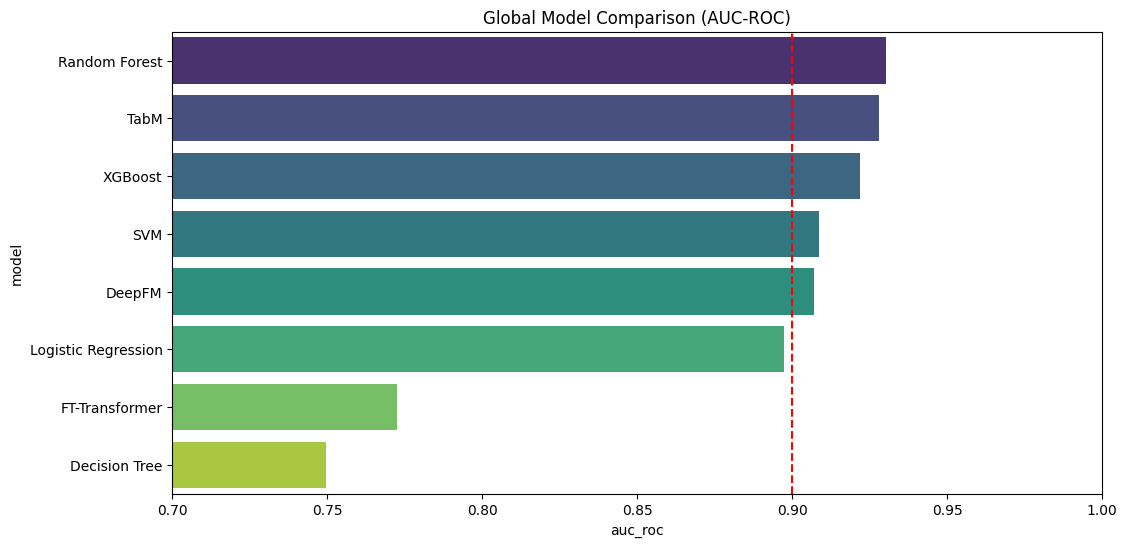

In [7]:
plt.figure(figsize=(12, 6))
sns.barplot(data=final_df, x='auc_roc', y='model', palette='viridis')
plt.axvline(x=0.9, color='red', linestyle='--', label='90% AUC Baseline')
plt.title("Global Model Comparison (AUC-ROC)")
plt.xlim(0.7, 1.0)
plt.show()